# Cliff Walking

In [7]:
import time
import random
import numpy as np

In [75]:
class Env():
    def __init__(self, length, height):
        # define the height and length of the map
        self.length = length
        self.height = height
        # define the agent's start position
        self.x = 0
        self.y = 0

    def render(self, frames=50):
        for i in range(self.height):
            if i == 0: # cliff is in the line 0
                line = ['S'] + ['x']*(self.length - 2) + ['T'] # 'S':start, 'T':terminal, 'x':the cliff
            else:
                line = ['.'] * self.length
            if self.x == i:
                line[self.y] = 'o' # mark the agent's position as 'o'
            print(''.join(line))
        print('\033['+str(self.height+1)+'A')  # printer go back to top-left 
        time.sleep(1.0 / frames)

    def step(self, action):
        """4 legal actions, 0:up, 1:down, 2:left, 3:right"""
        change = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        self.x = min(self.length - 1, max(0, self.x + change[action][0]))
        self.y = min(self.height - 1, max(0, self.y + change[action][1]))

        states = [self.x, self.y]
        reward = -1
        terminal = False
        if self.y == 0: # if agent is on the cliff line "SxxxxxT"
            if self.x > 0: # if agent is not on the start position 
                terminal = True
                if self.x != self.length - 1: # if agent falls
                    reward = -100
        return reward, states, terminal

    def reset(self):
        self.x = 0
        self.y = 0

In [2]:
class Q_table():
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9):
        self.table = [0] * actions * length * height # initialize all Q(s,a) to zero
        self.actions = actions
        self.length = length
        self.height = height
        self.alpha = alpha
        self.gamma = gamma

    def _index(self, a, x, y):
        """Return the index of Q([x,y], a) in Q_table."""
        return a * self.height * self.length + x * self.length + y

    def _epsilon(self):
        return 0.1
        # version for better convergence:
        # """At the beginning epsilon is 0.2, after 300 episodes decades to 0.05, and eventually go to 0."""
        # return 20. / (num_episode + 100)

    def take_action(self, x, y, num_episode):
        """epsilon-greedy action selection"""
        if random.random() < self._epsilon():
            return int(random.random() * 4)
        else:
            actions_value = [self.table[self._index(a, x, y)] for a in range(self.actions)]
            return actions_value.index(max(actions_value))

    def max_q(self, x, y):
        actions_value = [self.table[self._index(a, x, y)] for a in range(self.actions)]
        return max(actions_value)

    def update(self, a, s0, s1, r, is_terminated):
        # both s0, s1 have the form [x,y]
        q_predict = self.table[self._index(a, s0[0], s0[1])]
        if not is_terminated:
            q_target = r + self.gamma * self.max_q(s1[0], s1[1])
        else:
            q_target = r
        self.table[self._index(a, s0[0], s0[1])] += self.alpha * (q_target - q_predict)

In [3]:
class Env():
    def __init__(self, length, height):
        # define the height and length of the map
        self.length = length
        self.height = height
        # define the agent's start position
        self.x = 0
        self.y = 0

    def render(self, frames=50):
        for i in range(self.height):
            if i == 0: # cliff is in the line 0
                line = ['S'] + ['x']*(self.length - 2) + ['T'] # 'S':start, 'T':terminal, 'x':the cliff
            else:
                line = ['.'] * self.length
            if self.x == i:
                line[self.y] = 'o' # mark the agent's position as 'o'
            print(''.join(line))
        print('\033['+str(self.height+1)+'A')  # printer go back to top-left 
        time.sleep(1.0 / frames)

    def step(self, action):
        """4 legal actions, 0:up, 1:down, 2:left, 3:right"""
        change = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        self.x = min(self.height - 1, max(0, self.x + change[action][0]))
        self.y = min(self.length - 1, max(0, self.y + change[action][1]))

        states = [self.x, self.y]
        reward = -1
        terminal = False
        if self.x == 0: # if agent is on the cliff line "SxxxxxT"
            if self.y > 0: # if agent is not on the start position 
                terminal = True
                if self.y != self.length - 1: # if agent falls
                    reward = -100
        return reward, states, terminal

    def reset(self):
        self.x = 0
        self.y = 0

In [4]:
class Q_table():
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9):
        self.table = [0] * actions * length * height # initialize all Q(s,a) to zero
        self.actions = actions
        self.length = length
        self.height = height
        self.alpha = alpha
        self.gamma = gamma

    def _index(self, a, x, y):
        """Return the index of Q([x,y], a) in Q_table."""
        return a * self.height * self.length + x * self.height + y

    def _epsilon(self, num_episode):
        # return 0.1
        # version for better convergence:
        # """At the beginning epsilon is 0.2, after 300 episodes decades to 0.05, and eventually go to 0."""
        return 20. / (num_episode + 100)

    # def take_action(self, x, y, num_episode):
        rand_percentile = random.random()
        if rand_percentile < self._epsilon(num_episode):
            # Exploration: Random Action
            # print(rand_percentile, '+', self._epsilon(num_episode))
            return random.randint(0, 3)
        else:
            # Exploitation: Greedy Action
            actions_values = []
            for act in range(self.actions):
                actions_values.append(self.table[self._index(act, x, y)])
            return np.argmax(actions_values)

    # def max_q(self, x, y):
    #     return max([self.table[self._index(act, x, y)] for act in range(self.actions)])
    
    # def update(self, a, s0, s1, r, is_terminated):
    #     # both s0, s1 have the form [x,y]
    #     # s0 -> S, S1 -> S', r -> R
    #     # qsa -> Q(S, A)
    #     qsa = self.table[self._index(a, s0[0], s0[1])]
    #     if is_terminated:
    #         td_target = r
    #     else:
    #         td_target = r + self.gamma * self.max_q(s0[0], s0[1])
    #     self.table[self._index(a, s0[0], s0[1])] += self.alpha * (td_target- qsa)
    def take_action(self, x, y, num_episode):
        if self._epsilon(num_episode) > random.random():
            return random.randint(0,3)
        else:
            arr=np.zeros(self.actions)
            max=-200
            id=0
            for i in range(self.actions):
                arr[i]=self.table[self._index(i,x,y)]
                if arr[i]>max:
                    id=i
                    max=arr[i]
            return id


    def max_q(self, x, y):
        # actions_value = [self.table[self._index(a, x, y)] for a in range(self.actions)]
        # return max(actions_value)
        arr=np.zeros(self.actions)
        max=-200
        id=0
        for i in range(self.actions):
            arr[i]=self.table[self._index(i,x,y)]
            if arr[i]>max:
                id=i
                max=arr[i]
        return max

    def update(self, a, s0, s1, r, is_terminated):
        # both s0, s1 have the form [x,y]
        
        pre=self.table[self._index(a,s0[0],s0[1])]
        if is_terminated:
            target=r
        else:
            target=r+self.gamma*self.max_q(s1[0],s1[1])
        self.table[self._index(a,s0[0],s0[1])]=pre+self.alpha*(target-pre)

In [5]:
def cliff_walk():
    ret_num_episode = []
    ret_episodic_reward = []
    env = Env(length=12, height=4)
    table = Q_table(length=12, height=4)
    for num_episode in range(3000):
        # within the whole learning process
        
        episodic_reward = 0
        is_terminated = False
        s0 = [0, 0]
    
        while not is_terminated:
            
            # within one episode
            action = table.take_action(s0[0], s0[1], num_episode)
            # observe R, S'
            r, s1, is_terminated = env.step(action)
            
            # s0 -> S, S1 -> S', r -> R
            table.update(action, s0, s1, r, is_terminated)
            episodic_reward += r
            # env.render(frames=100)
            s0 = s1
        
        if num_episode % 20 == 0:
            print('\r Episode: {0}, Reward: {1}'.format(num_episode, episodic_reward), end='')
        
        ret_num_episode.append(num_episode)
        ret_episodic_reward.append(episodic_reward)
        
        # print([table.table[table._index(a, 0, 0)] for a in range(4)])
        
        env.reset()
        
        
    return ret_num_episode, ret_episodic_reward, env, table

In [19]:
nums, rewards, env, table = cliff_walk()

 Episode: 2980, Reward: -173

In [9]:
def get_item(table, x, y):
    return [table.table[table._index(a, x, y)] for a in range(4)]

def way(dir):
    if dir == 0:
        return '➡️'
    elif dir == 1:
        return '⬅️'
    elif dir == 2:
        return '⬇️'
    elif dir == 3:
        return '⬆️'


## print_all_actions(table):
for i in range(env.height-1, -1, -1):
    for j in range(0, env.length):
        print(way(np.argmax(get_item(table, i, j))), end='')
    print()

➡️➡️➡️⬇️➡️⬇️⬇️⬅️➡️⬅️⬆️⬆️
➡️⬆️⬆️➡️➡️➡️➡️⬇️➡️⬇️⬇️⬅️
➡️⬆️⬅️⬅️➡️⬆️⬆️➡️➡️➡️➡️⬇️
⬆️➡️➡️➡️➡️⬆️⬅️⬅️➡️⬆️⬆️➡️


In [16]:
get_item(table, 0, 1)

[0, 0, 0, 0]

In [11]:
env.render(frames=3000)

oxxxxxxxxxxT
............
............
............



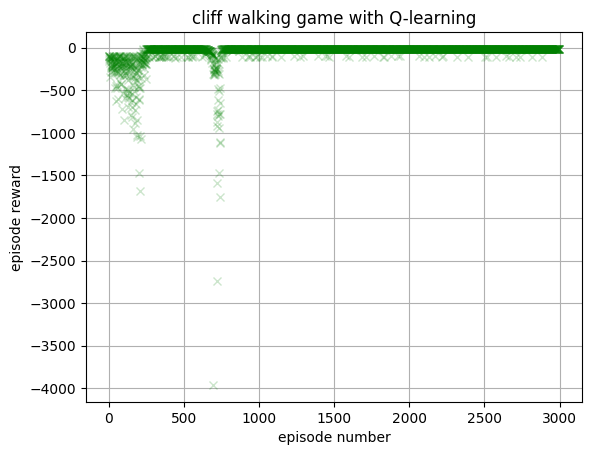

In [20]:
import matplotlib.pyplot as plt

plt.xlabel('episode number')
plt.ylabel('episode reward')
plt.title('cliff walking game with Q-learning')

plt.plot(nums, rewards, marker='x', color='g', linewidth=0, alpha=0.2)
plt.grid()

plt.show()

# MountainCar-v0

In [5]:
import numpy as np

import gym
from gym import wrappers

off_policy = False # if True use off-policy q-learning update, if False, use on-policy SARSA update

n_states = 40
iter_max = 5000

initial_lr = 1.0 # Learning rate
min_lr = 0.003
gamma = 1.0
t_max = 10000
eps = 0.1

def run_episode(env, policy=None, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    for _ in range(t_max):
        if render:
            env.render()
        if policy is None:
            action = env.action_space.sample()
        else:
            a,b = obs_to_state(env, obs)
            action = policy[a][b]
        obs, reward, done, _ = env.step(action)
        total_reward += gamma ** step_idx * reward
        step_idx += 1
        if done:
            break
    return total_reward

def obs_to_state(env, obs):
    """ Maps an observation to state """
    # we quantify the continous state space into discrete space
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_dx = (env_high - env_low) / n_states
    a = int((obs[0] - env_low[0])/env_dx[0])
    b = int((obs[1] - env_low[1])/env_dx[1])
    a = a if a < n_states else n_states - 1
    b = b if b < n_states else n_states - 1
    return a, b

if __name__ == '__main__':
    env_name = 'MountainCar-v0'
    env = gym.make(env_name)
    # env.seed(0)
    np.random.seed(0)
    if off_policy == True:
        print ('----- using Q Learning -----')
    else:
        print('------ using SARSA Learning ---')

    q_table = np.zeros((n_states, n_states, 3))
    for i in range(iter_max):
        obs = env.reset()
        total_reward = 0
        ## eta: learning rate is decreased at each step
        eta = max(min_lr, initial_lr * (0.85 ** (i//100)))
        for j in range(t_max):
            a, b = obs_to_state(env, obs)
            if np.random.uniform(0, 1) < eps:
                action = np.random.choice(env.action_space.n)
            else:
                action = np.argmax(q_table[a][b])
            obs, reward, done, _ = env.step(action)
            total_reward += reward
            # update q table
            a_, b_ = obs_to_state(env, obs)
            if off_policy == True:
                # use q-learning update (off-policy learning)
                q_table[a][b][action] = q_table[a][b][action] + eta * (reward + gamma *  np.max(q_table[a_][b_]) - q_table[a][b][action])
            else:
                # use SARSA update (on-policy learning)
                # epsilon-greedy policy on Q again
                if np.random.uniform(0,1) < eps:
                    action_ = np.random.choice(env.action_space.n)
                else:
                    action_ = np.argmax(q_table[a_][b_])
                q_table[a][b][action] = q_table[a][b][action] + eta * (reward + gamma *  q_table[a_][b_][action_] - q_table[a][b][action])
            if done:
                break
        if i % 200 == 0:
            print('Iteration #%d -- Total reward = %d.' %(i+1, total_reward))
    solution_policy = np.argmax(q_table, axis=2)
    solution_policy_scores = [run_episode(env, solution_policy, False) for _ in range(100)]
    print("Average score of solution = ", np.mean(solution_policy_scores))
    # Animate it
    for _ in range(2):
        run_episode(env, solution_policy, True)
    env.close()

------ using SARSA Learning ---


TypeError: only size-1 arrays can be converted to Python scalars